# Functions

**binarizing**

In [1]:
def to_bin(images: list):
    for i in range(len(images)):
        gray = cv2.GaussianBlur(images[i], (11,11), 0)
        images[i] = cv2.ximgproc.niBlackThreshold(gray, 255, cv2.THRESH_BINARY_INV, 41, -0.1,
                                            binarizationMethod=cv2.ximgproc.BINARIZATION_NICK)
    return images

**Preparing labels**

In [2]:
def prepare_labels(labels):
    # Assuming labels are a list of strings representing digits
    prepared_labels = []
    for label in labels:
        label_digits = [int(char) for char in str(label)]
        prepared_labels.append(label_digits)
    return tf.ragged.constant(prepared_labels, dtype=tf.int64).to_tensor(default_value=-1)

**Resize images to desire size**

In [3]:
def res_images(images, target_height=32, target_width=128):
    resized_images = []
    for img in images:
        # Ensure the image is a 3D array (height, width, channels)
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)  # Add a channel dimension for grayscale images
        
        # Resize the image
        resized_img = tf.image.resize(img, [target_height, target_width], method='nearest')
        resized_img = resized_img.numpy()  # Convert back to a numpy array

        resized_images.append(resized_img)
    
    return np.array(resized_images)

**Decoding the predictions**

In [4]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :8
    ]
    # Iterate over the results and get back the text
    return results

**Num to char**

In [5]:
def num2char(inp):
    inp = inp.numpy().tolist()
    result = []
    for sub in inp:
        tmp = []
        for char in sub:
            if char != -1:
                tmp.append(str(char))
        result.append(tmp)
    return result

# libraries

In [6]:
import sys
sys.path.append('./../')

In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import Levenshtein
from Metrics import cer
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Bidirectional, LSTM, Input, Reshape, Dense, Dropout, BatchNormalization

# Fetch Data

In [8]:
path = './../Dataset/ORAND-CAR-2014/'

In [9]:
xa_train, xa_test = [cv2.cvtColor(cv2.imread(f'{path}/CAR-A/a_train_images/{img}'), cv2. COLOR_BGR2GRAY) for img in os.listdir(f'{path}/CAR-A/a_train_images')], [cv2.cvtColor(cv2.imread(f'{path}/CAR-A/a_test_images/{img}'), cv2. COLOR_BGR2GRAY) for img in os.listdir(f'{path}/CAR-A/a_test_images')]

In [10]:
xb_train, xb_test = [cv2.cvtColor(cv2.imread(f'{path}/CAR-B/b_train_images/{img}'), cv2. COLOR_BGR2GRAY) for img in os.listdir(f'{path}/CAR-B/b_train_images')], [cv2.cvtColor(cv2.imread(f'{path}/CAR-B/b_test_images/{img}'), cv2. COLOR_BGR2GRAY) for img in os.listdir(f'{path}/CAR-B/b_test_images')]

In [11]:
x_train = xa_train + xb_train + xa_test + xb_test

In [12]:
x_train = to_bin(x_train)

In [13]:
ya_train, ya_test, yb_train, yb_test = [], [], [], []
with open(f'{path}CAR-A/a_train_gt.txt', 'r') as a_train, open(f'{path}CAR-A/a_test_gt.txt', 'r') as a_test, open(f'{path}CAR-B/b_train_gt.txt', 'r') as b_train, open(f'{path}CAR-B/b_test_gt.txt', 'r') as b_test:
    for i in a_train:
        ya_train.append(i.split()[1])
    for i in a_test:
        ya_test.append(i.split()[1])
    for i in b_train:
        yb_train.append(i.split()[1])
    for i in b_test:
        yb_test.append(i.split()[1])
y_train = ya_train + yb_train + ya_test + yb_test

plot several samples of training data **Befor** resize

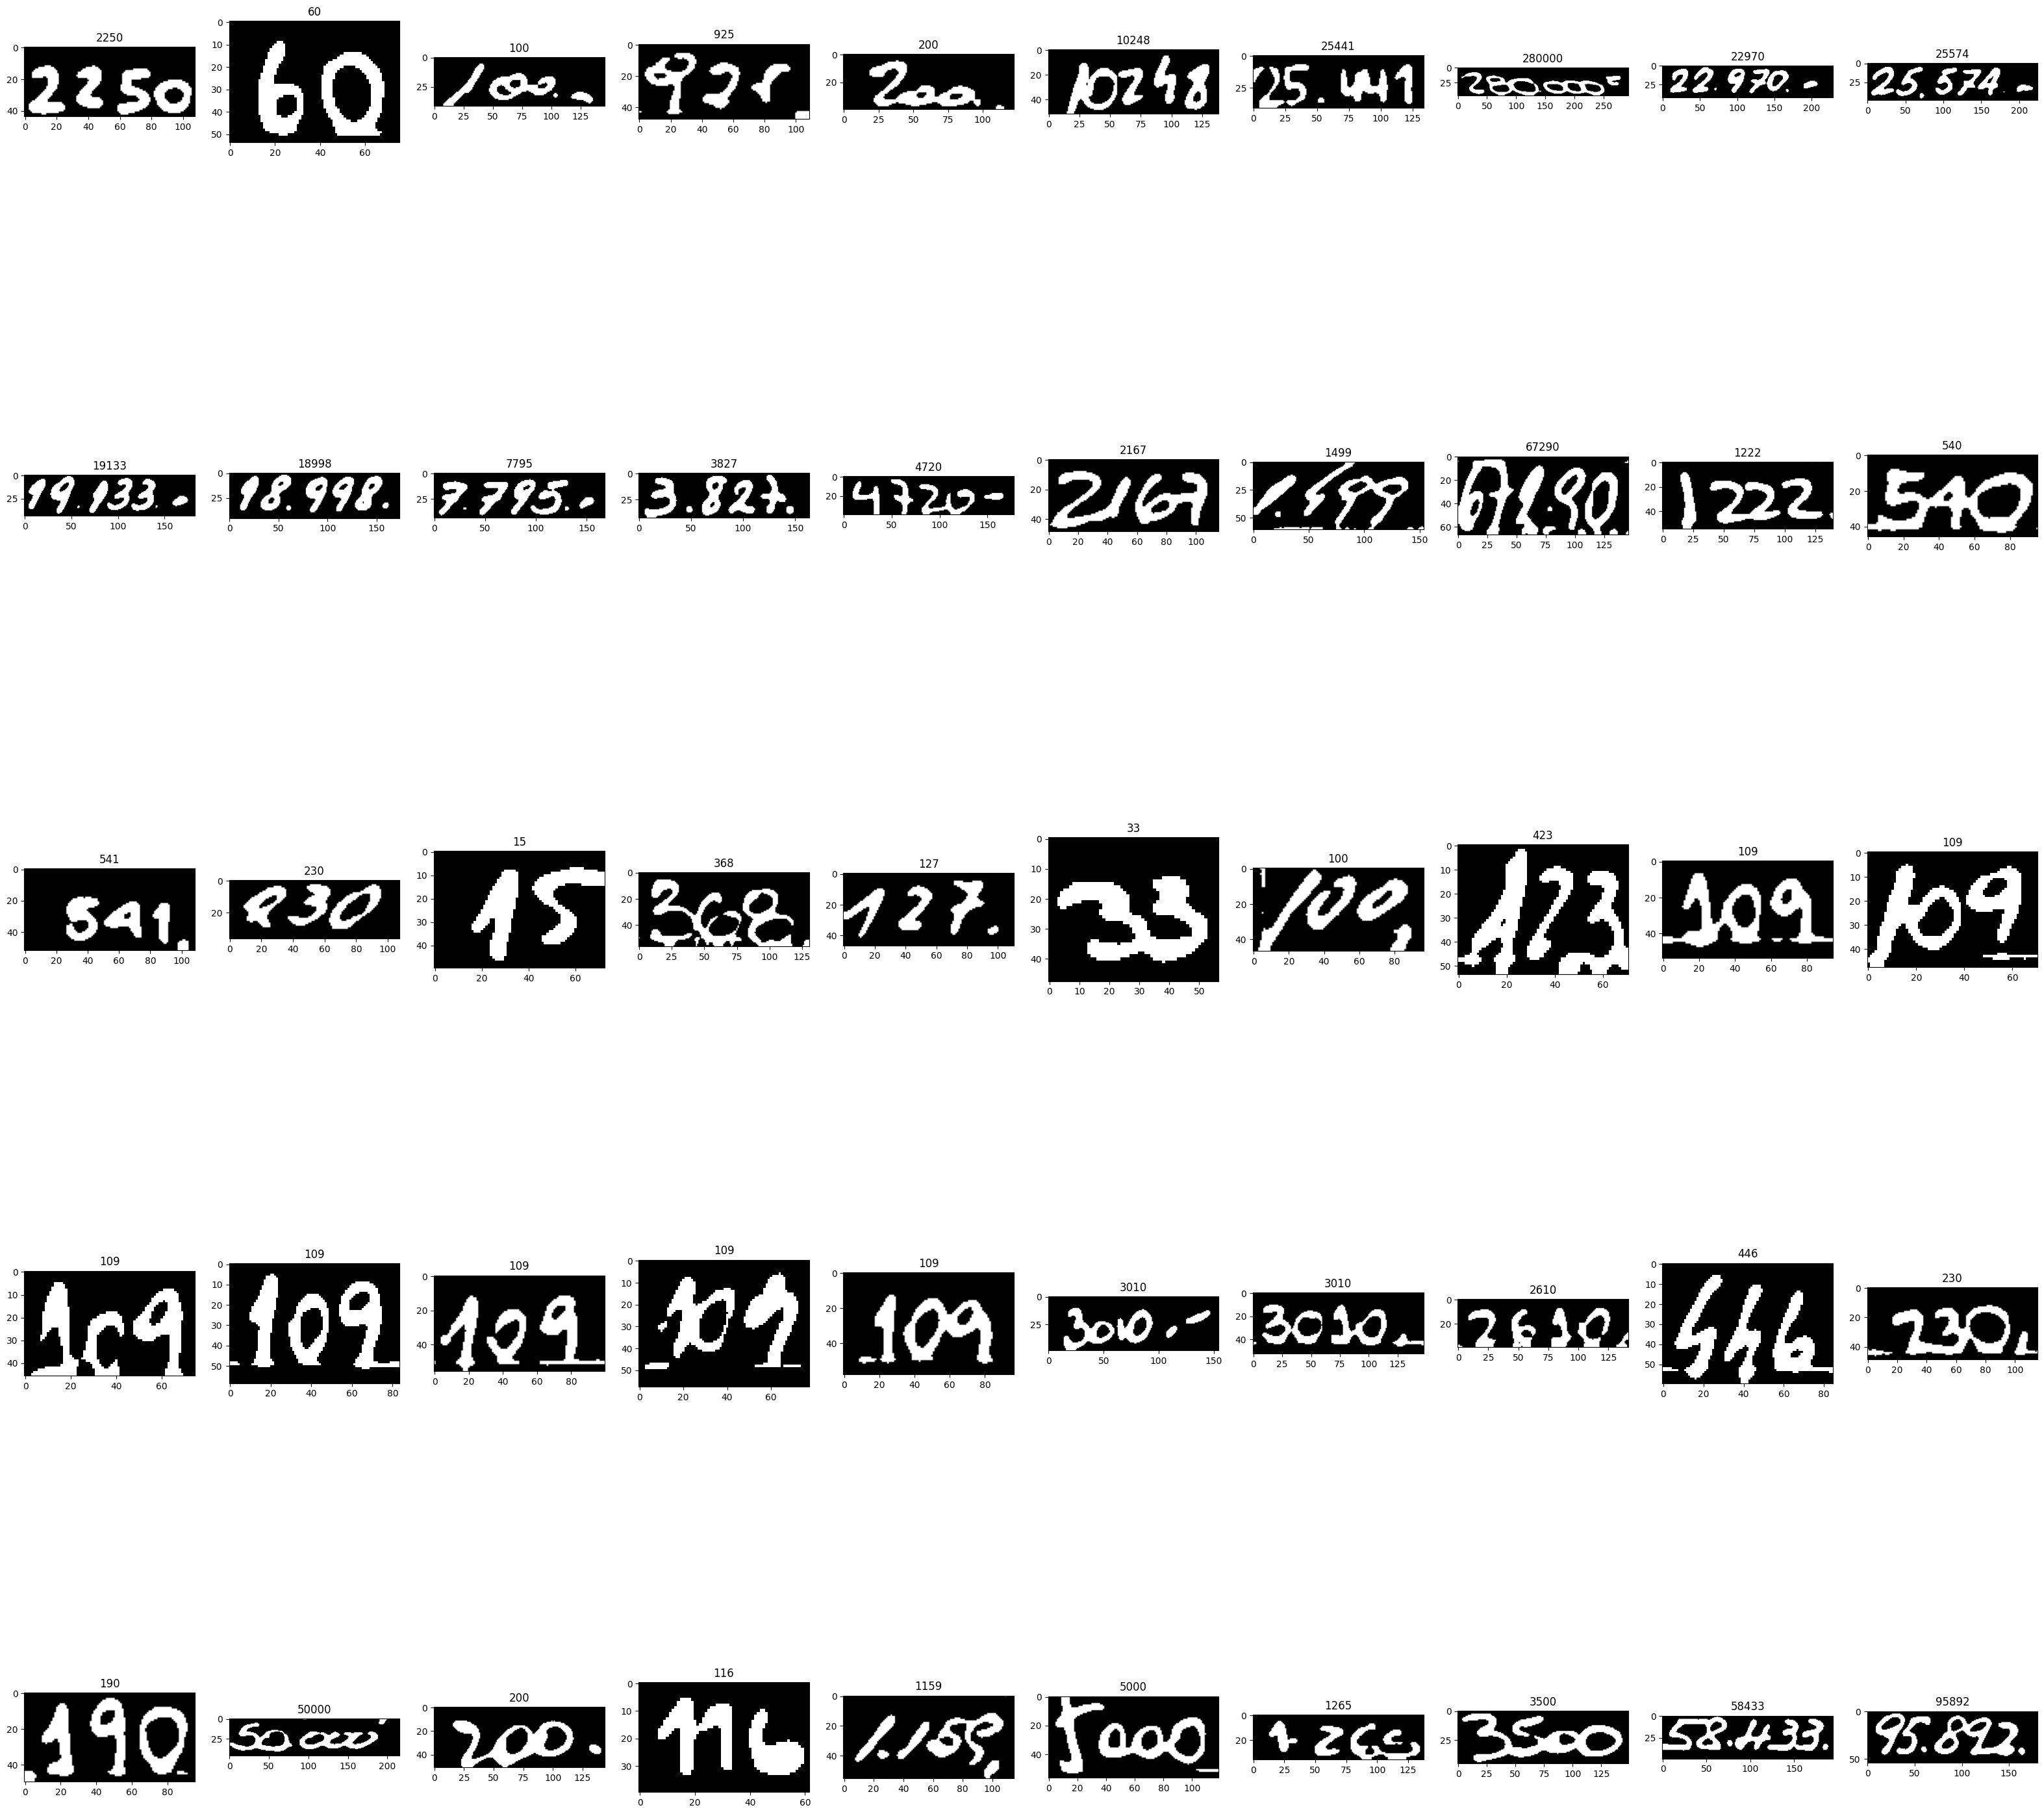

In [14]:
fig, ax = plt.subplots(5,10, figsize=(40, 40))
ax = ax.flatten()
for i in range(50):
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].title.set_text(y_train[i])

In [15]:
x_train = res_images(x_train)

plot several samples of training data **After** resize

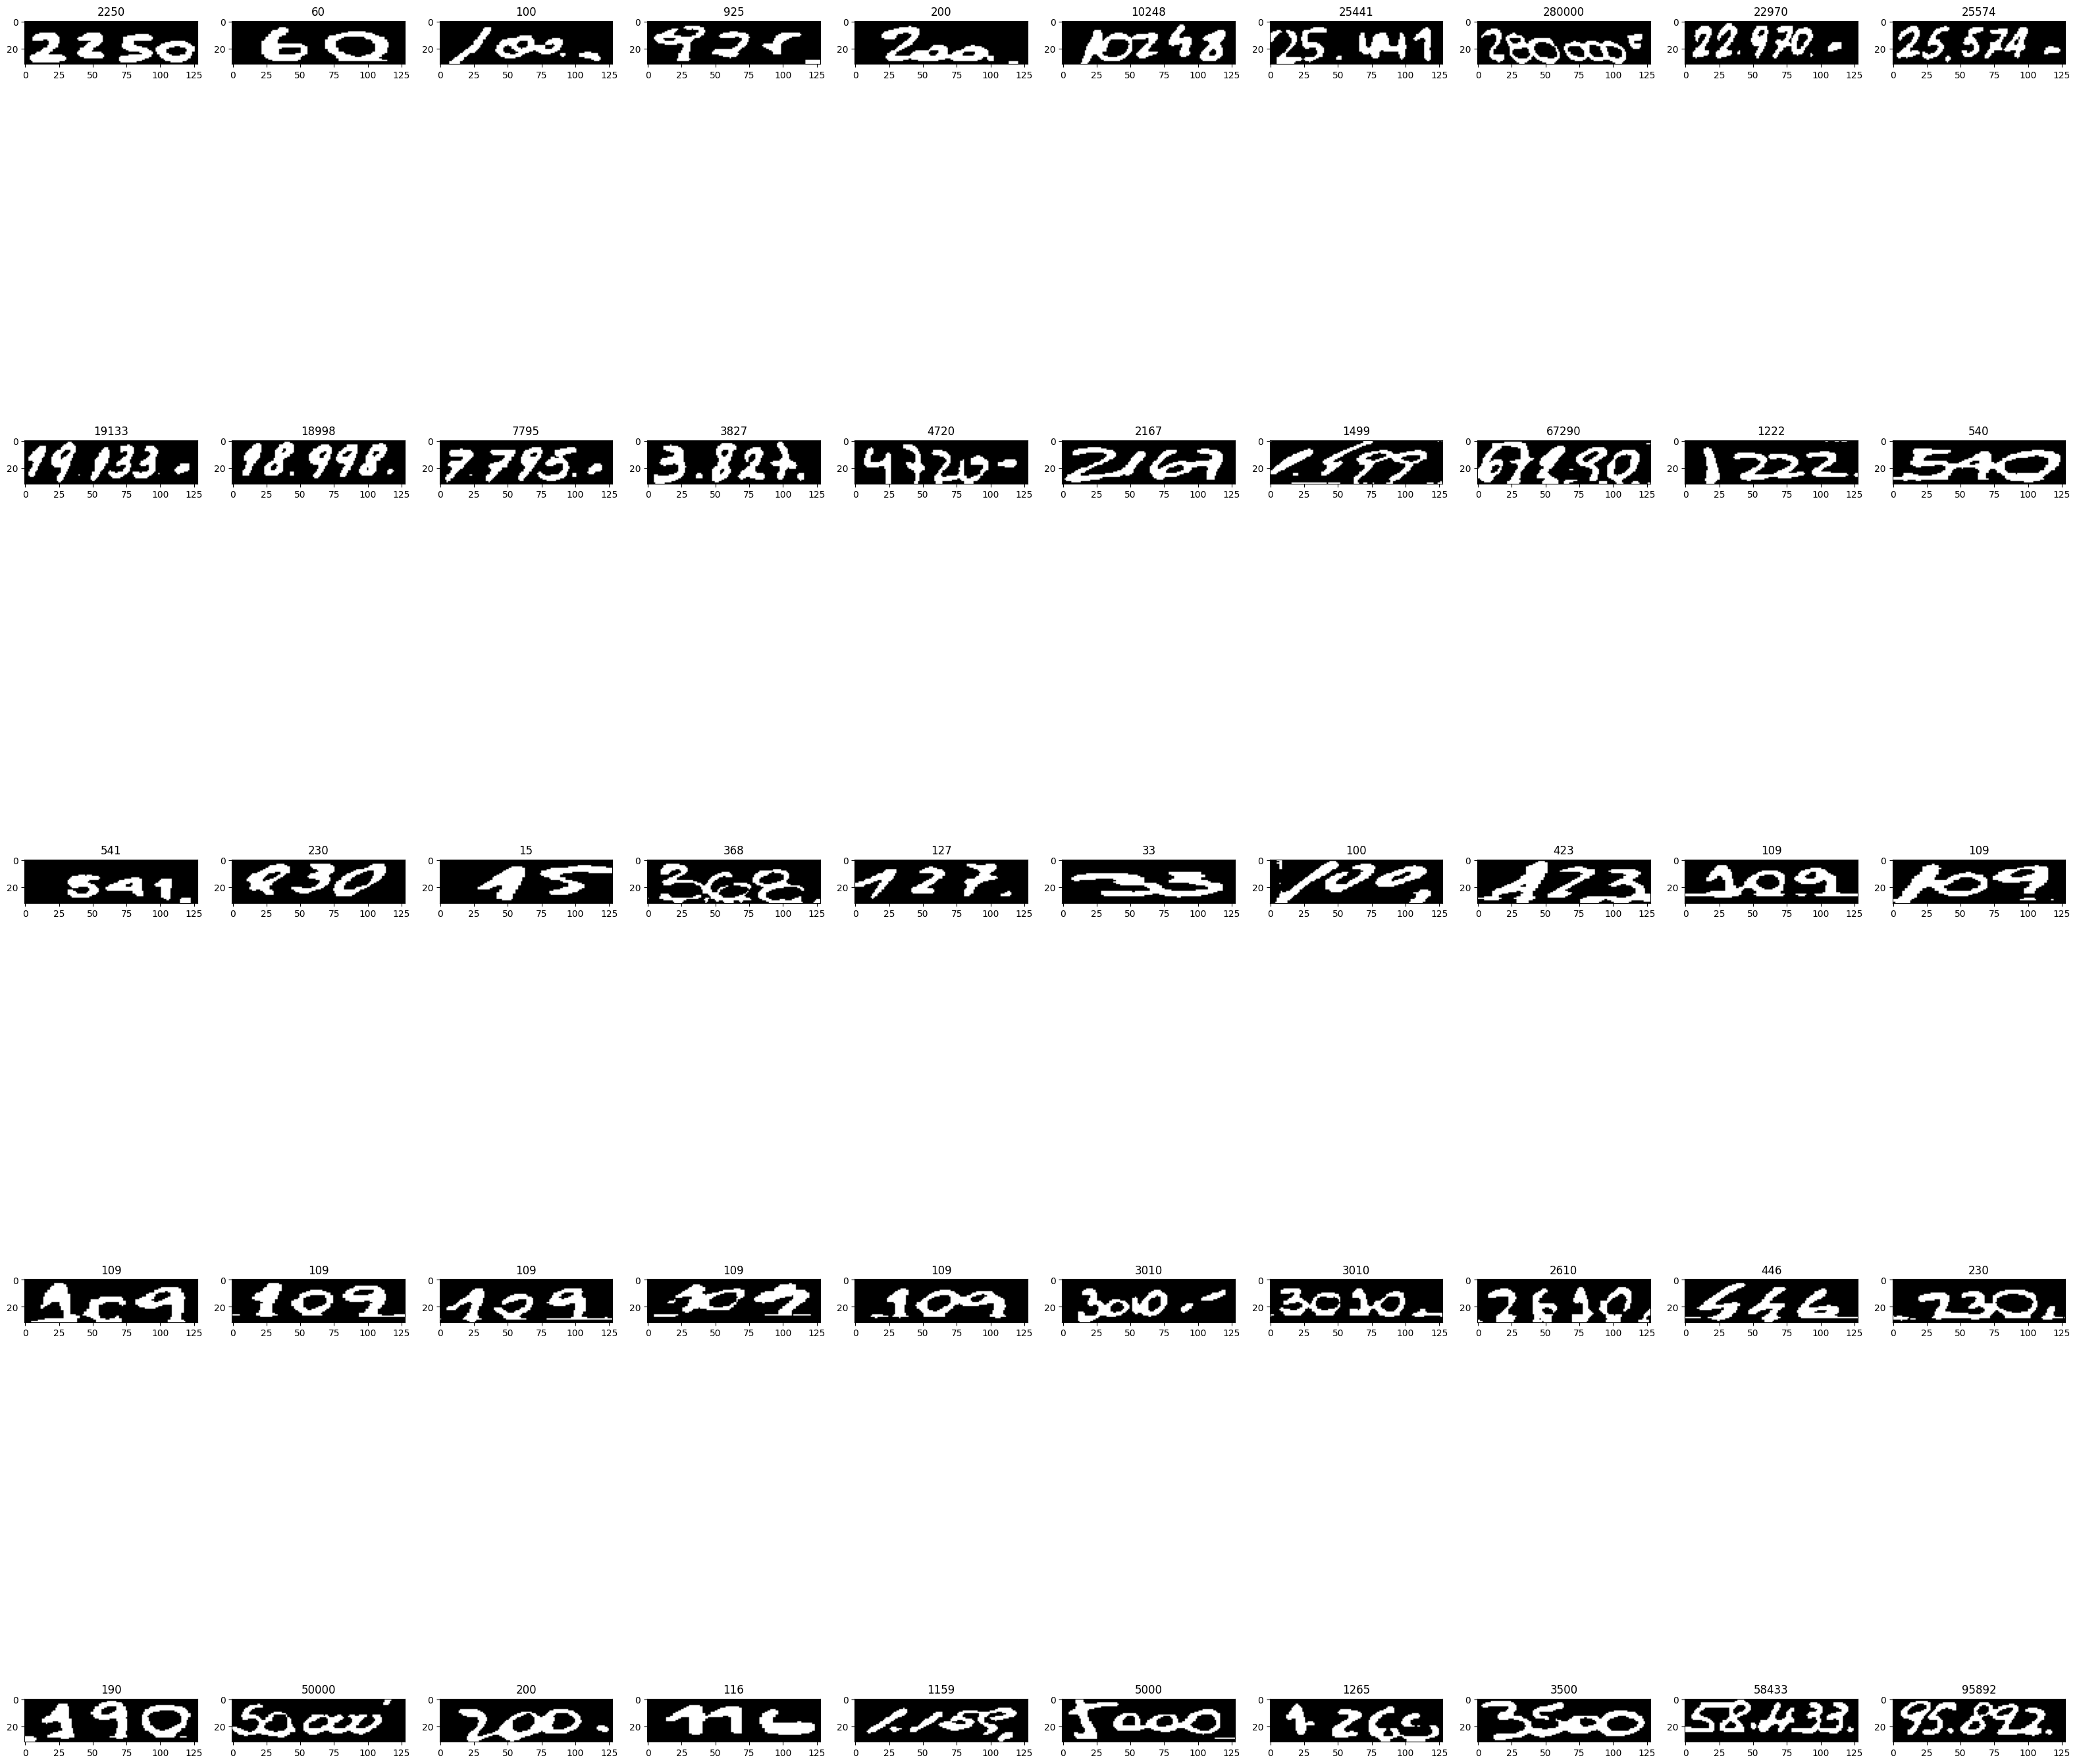

In [16]:
fig, ax = plt.subplots(5,10, figsize=(40, 40))
ax = ax.flatten()
for i in range(50):  
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].title.set_text(y_train[i])

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

**Normalizing**

In [18]:
x_train, x_test = x_train /255., x_test/255.

shape **Before** augmentation

In [19]:
print(f'x_train shape : {x_train.shape}, y_train shape : {len(y_train)} ')

x_train shape : (9375, 32, 128, 1), y_train shape : 9375 


In [20]:
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, height_shift_range=0.2, brightness_range=[0.2, 0.4])

In [21]:
x_aug, y_aug = datagen.flow(x_train, y_train, batch_size=4096)[0]

In [22]:
x_train = np.concatenate((x_train, x_aug), axis=0)
y_train = np.concatenate((y_train, y_aug), axis=0)

shape **After** augmentation

In [23]:
print(f'x_train shape : {x_train.shape}, y_train shape : {y_train.shape} ')

x_train shape : (13471, 32, 128, 1), y_train shape : (13471,) 


In [24]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2, random_state=42)

**Prepare labels**

In [25]:
y_train = prepare_labels(y_train)
y_val = prepare_labels(y_val)
y_test = prepare_labels(y_test)

In [26]:
x_train.shape

(13471, 32, 128, 1)

In [27]:
def calculate_edit_distance(labels, predictions):
    # Ensure labels are dense tensors with rank 2 (batch_size, max_label_length)
    labels = tf.expand_dims(labels, axis=-1)
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Ensure predictions are dense tensors and have rank 2 (batch_size, max_label_length)
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    max_len = max(len(label) for label in y_train)
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    predictions_decoded = tf.expand_dims(predictions_decoded, axis=-1)
    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

    # Ensure both sparse tensors have the same rank
    labels_rank = tf.rank(sparse_labels)
    predictions_rank = tf.rank(sparse_predictions)

    if labels_rank < predictions_rank:
        sparse_labels = tf.sparse.expand_dims(sparse_labels, axis=-1)
    elif labels_rank > predictions_rank:
        sparse_predictions = tf.sparse.expand_dims(sparse_predictions, axis=-1)

    # Compute the edit distance
    edit_distances = tf.edit_distance(sparse_predictions, sparse_labels, normalize=False)
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.validation_images = validation_images
        self.validation_labels = validation_labels

In [28]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_size = tf.shape(y_true)[0]
        input_length = tf.shape(y_pred)[1]
        label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, -1), dtype=tf.int64), axis=1)

        input_length = tf.fill([batch_size, 1], input_length)
        label_length = tf.expand_dims(label_length, 1)

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [29]:
def build_model():
    image_width, image_height = 128, 32
    # Inputs to the model
    input_img = keras.Input(shape=(image_height, image_width, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    x = keras.layers.Dropout(0.3)(x)
    
    x = keras.layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = BatchNormalization()(x)
    x = keras.layers.AveragePooling2D((2, 2), name="avgpool1")(x)
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 8x smaller. The number of
    # filters in the last layer is 512. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 8), (image_height // 8) * 512)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(128, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.3)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(512, return_sequences=True)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True)
    )(x)
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        11, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_digit_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_digit_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 128, 64)  640         ['image[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 128, 64)  256        ['Conv1[0][0]']                  
 alization)                                                                                       
                                                                       

In [30]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model, x_val, y_val)
# Define a callback to modify the learning rate dynamically
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.0001
)

# Train the model.
model = build_model()
history = model.fit(
    x={"image": x_train, "label": y_train},
    validation_data=({"image": x_val, "label": y_val}),
    epochs=150,
    # callbacks=[edit_distance_callback],
    batch_size=64
)


Epoch 1/150
211/211 [==============================] - 27s 84ms/step - loss: 11.0050 - val_loss: 11.0213
Epoch 2/150
211/211 [==============================] - 16s 74ms/step - loss: 9.3512 - val_loss: 8.6066
Epoch 3/150
211/211 [==============================] - 16s 74ms/step - loss: 7.8539 - val_loss: 4.9794
Epoch 4/150
211/211 [==============================] - 16s 74ms/step - loss: 6.8046 - val_loss: 4.0829
Epoch 5/150
211/211 [==============================] - 16s 74ms/step - loss: 6.2231 - val_loss: 3.5853
Epoch 6/150
211/211 [==============================] - 16s 74ms/step - loss: 5.7654 - val_loss: 3.1417
Epoch 7/150
211/211 [==============================] - 16s 74ms/step - loss: 5.4492 - val_loss: 3.0934
Epoch 8/150
211/211 [==============================] - 16s 74ms/step - loss: 5.1803 - val_loss: 2.9085
Epoch 9/150
211/211 [==============================] - 16s 74ms/step - loss: 4.9747 - val_loss: 2.5529
Epoch 10/150
211/211 [==============================] - 16s 74ms/step -

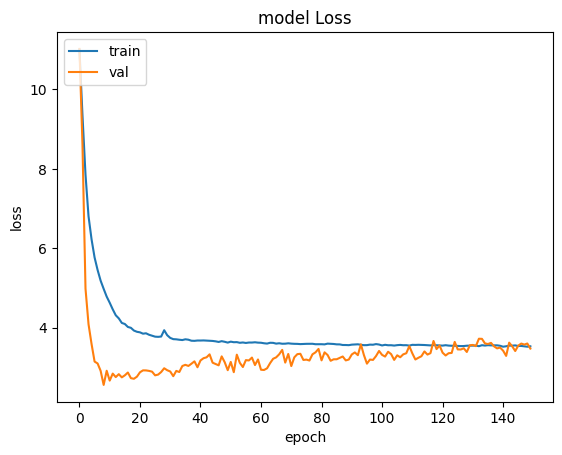

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Save Model

In [32]:
model.save('my_model_c1.h5')

# Prediction

In [33]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

**make predictions**

In [34]:
pre = prediction_model.predict(x_test)

59/59 [==============================] - 2s 14ms/step


**Decode predictions**

In [35]:
predicted_labels = decode_batch_predictions(pre)

**Convert Numbers to Characters**

In [36]:
predicted_labels = num2char(predicted_labels)
y_test = num2char(y_test)

# Error analysis

**Character error rate**

In [37]:
res, same = 0, 0
for i in range(len(y_test)):
    if y_test[i] == predicted_labels[i]:
        same += 1
    res += cer(y_test[i], predicted_labels[i])
print(f'Mean of error rate is {res/len(y_test)}')

Mean of error rate is 12.699555555555563


In [38]:
print(f'{same} exact match of {len(x_test)}')

1048 exact match of 1875


**Several predicted output**

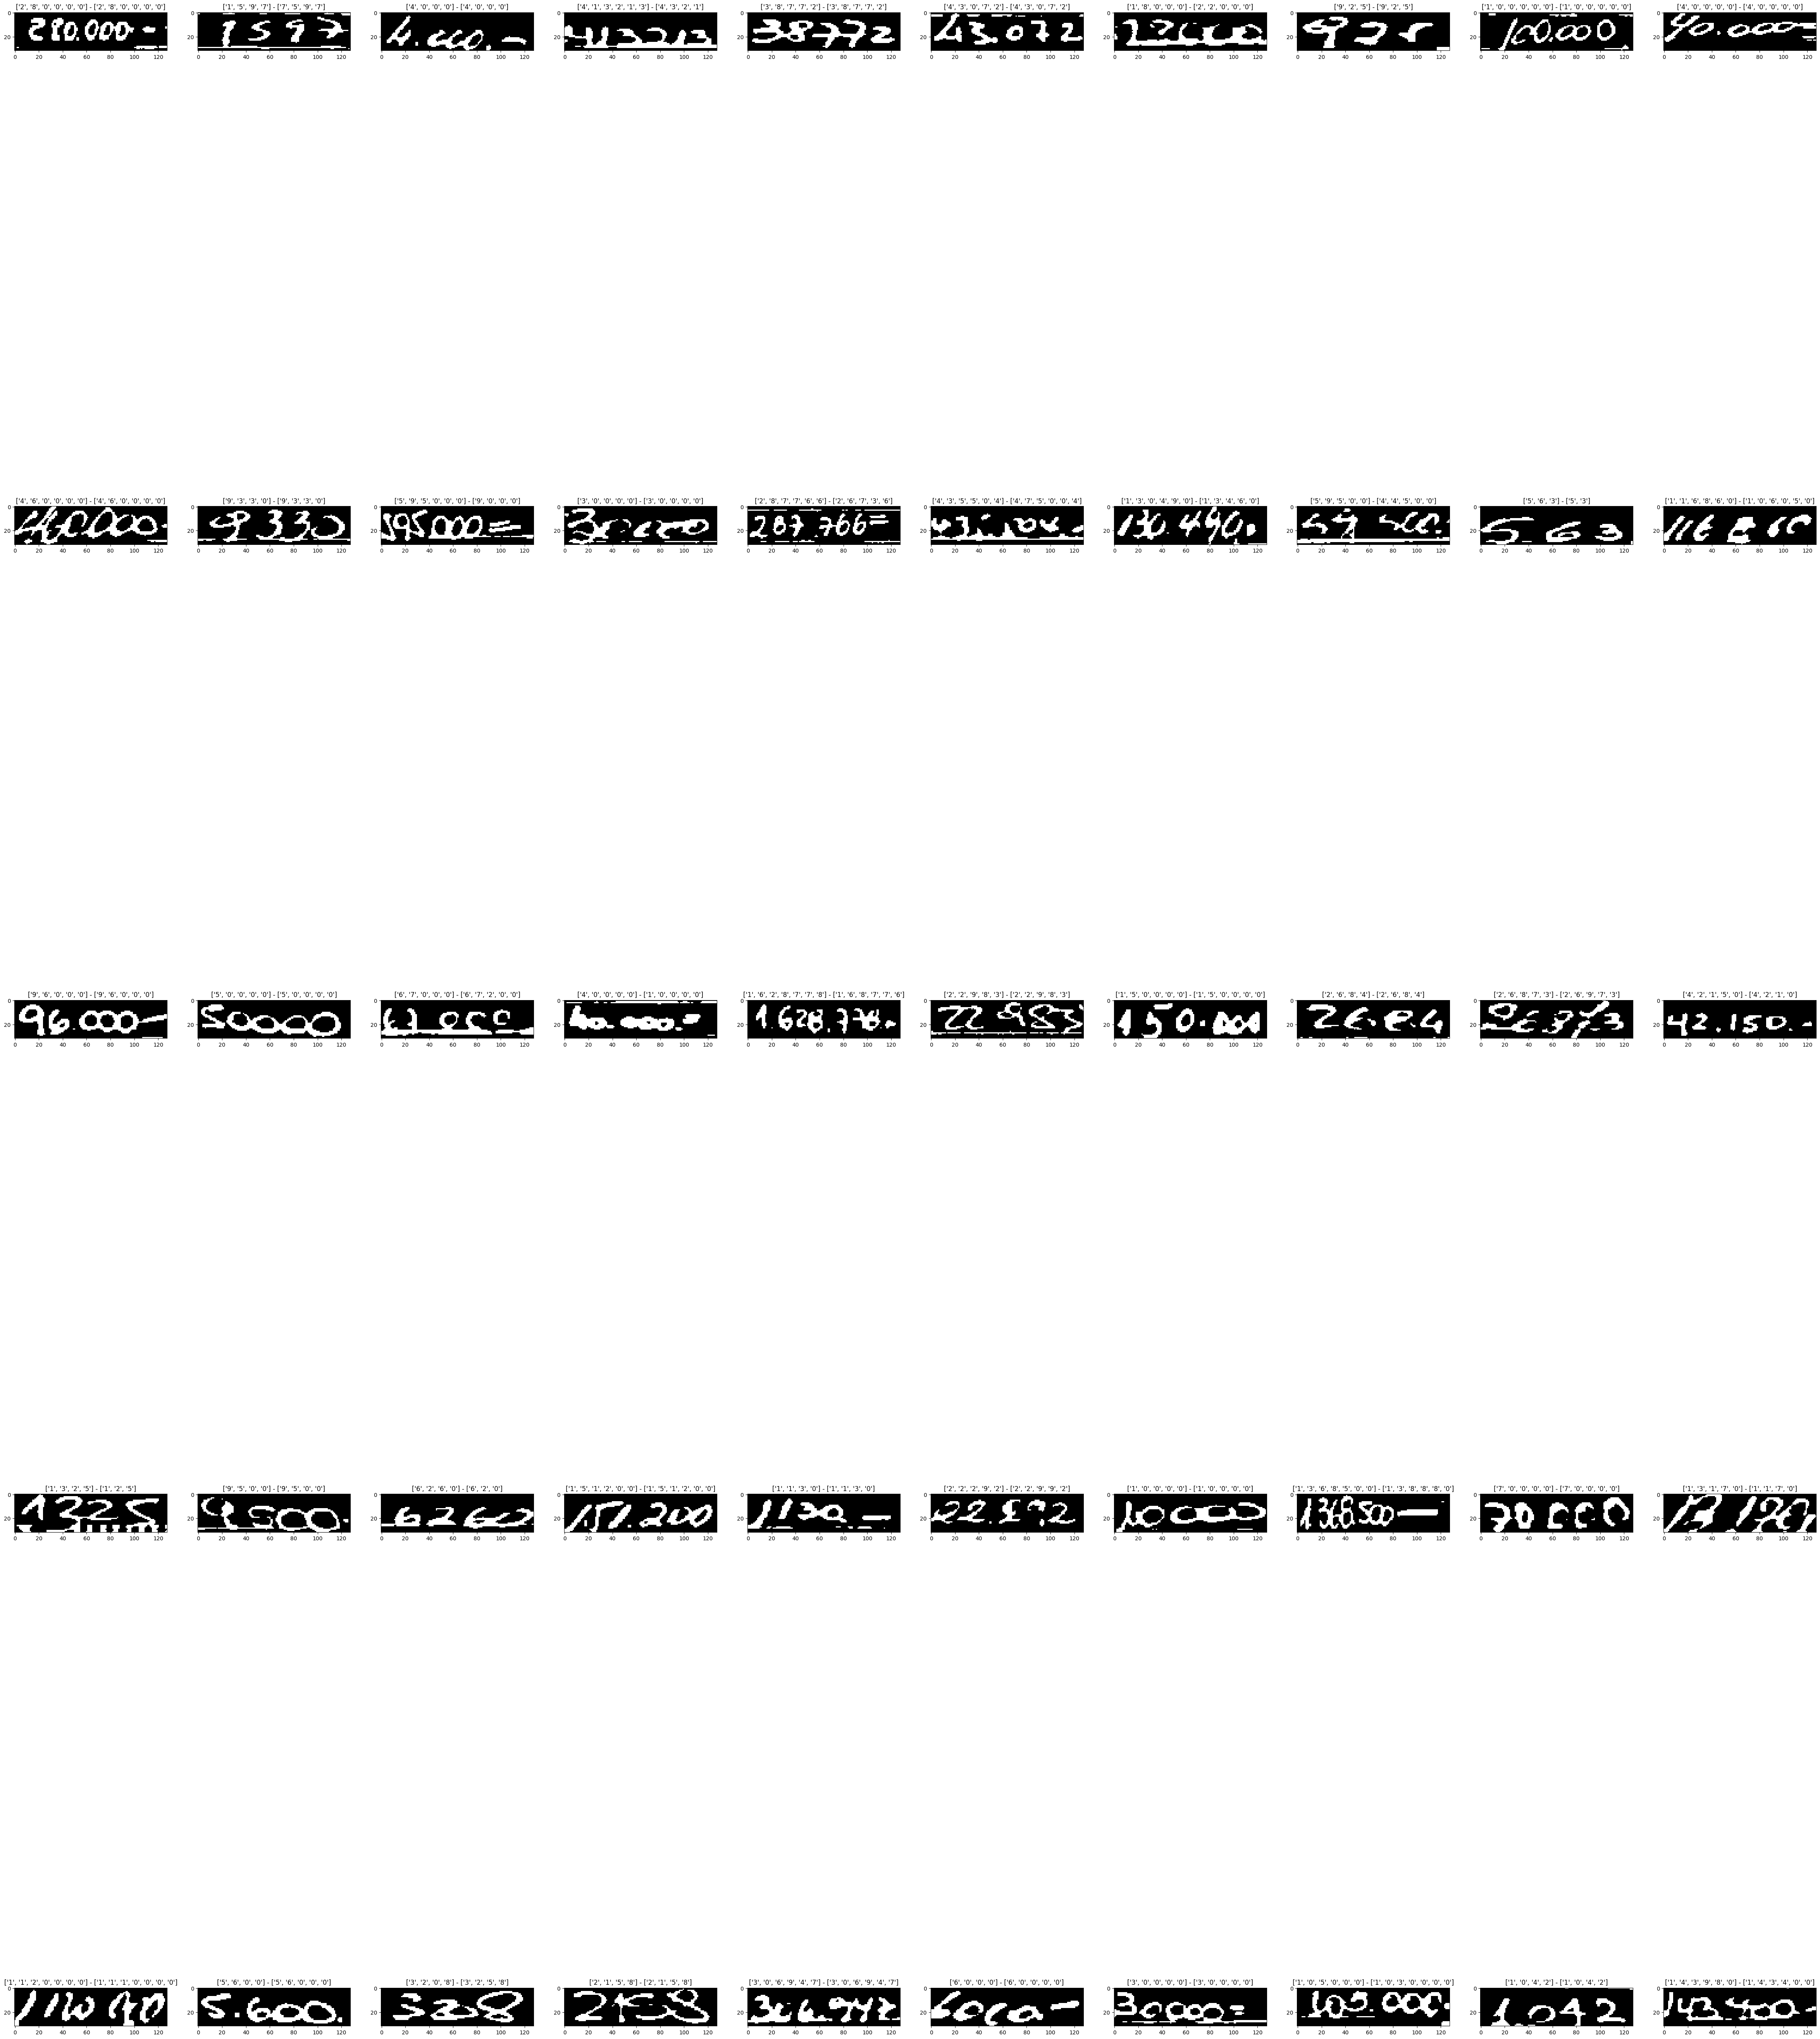

In [39]:
fig, ax = plt.subplots(5,10, figsize=(60, 80))
ax = ax.flatten()
for i in range(50):  
    ax[i].imshow(x_test[i], cmap='gray')
    ax[i].title.set_text(f'{y_test[i]} - {predicted_labels[i]}')

In [40]:
longer, shorter, same, exact_match = [], [], [], 0
length_test = len(y_test)
for i in range(length_test):
    if len(predicted_labels[i]) > len(y_test[i]):
        longer.append([y_test[i], predicted_labels[i]])
    elif len(predicted_labels[i]) < len(y_test[i]):
        shorter.append([y_test[i], predicted_labels[i]])
    else:
        same.append([y_test[i], predicted_labels[i]])
        if y_test[i] == predicted_labels[i]:
            exact_match += 1

In [41]:
print(f'longer predected : {len(longer)}\nsame predected : {len(same)} - exact match : {exact_match} \nshorter predected : {len(shorter)} ')

longer predected : 100
same predected : 1425 - exact match : 1048 
shorter predected : 350 


**find labels which has mismatch**

In [42]:
tmp = []
for i in same:
    if i[0] != i[1]:
        tmp.append(i)

In [43]:
num_dict = {}
for i in range(10):
    num_dict[str(i)] = []

In [44]:
for i in tmp:
    for ind in range(len(i[0])):
        if i[0][ind] != i[1][ind]:
            num_dict[i[0][ind]].append(i[1][ind])

**Distribution of mismatches**

In [45]:
for i in range(10):
    print(f'Distribuation of mismatches for {i} : {sorted(set(num_dict[str(i)]))}')

Distribuation of mismatches for 0 : ['1', '2', '3', '4', '5', '6', '7', '8', '9']
Distribuation of mismatches for 1 : ['0', '2', '3', '4', '6', '7', '9']
Distribuation of mismatches for 2 : ['0', '1', '3', '4', '5', '6', '7', '8', '9']
Distribuation of mismatches for 3 : ['0', '1', '2', '5', '7', '9']
Distribuation of mismatches for 4 : ['0', '1', '2', '3', '6', '7', '8', '9']
Distribuation of mismatches for 5 : ['0', '1', '2', '3', '4', '6', '7', '8', '9']
Distribuation of mismatches for 6 : ['0', '1', '2', '3', '4', '5', '7', '8']
Distribuation of mismatches for 7 : ['0', '1', '2', '3', '4', '5', '8', '9']
Distribuation of mismatches for 8 : ['0', '1', '2', '3', '4', '5', '6', '7', '9']
Distribuation of mismatches for 9 : ['0', '1', '2', '3', '4', '5', '7', '8']


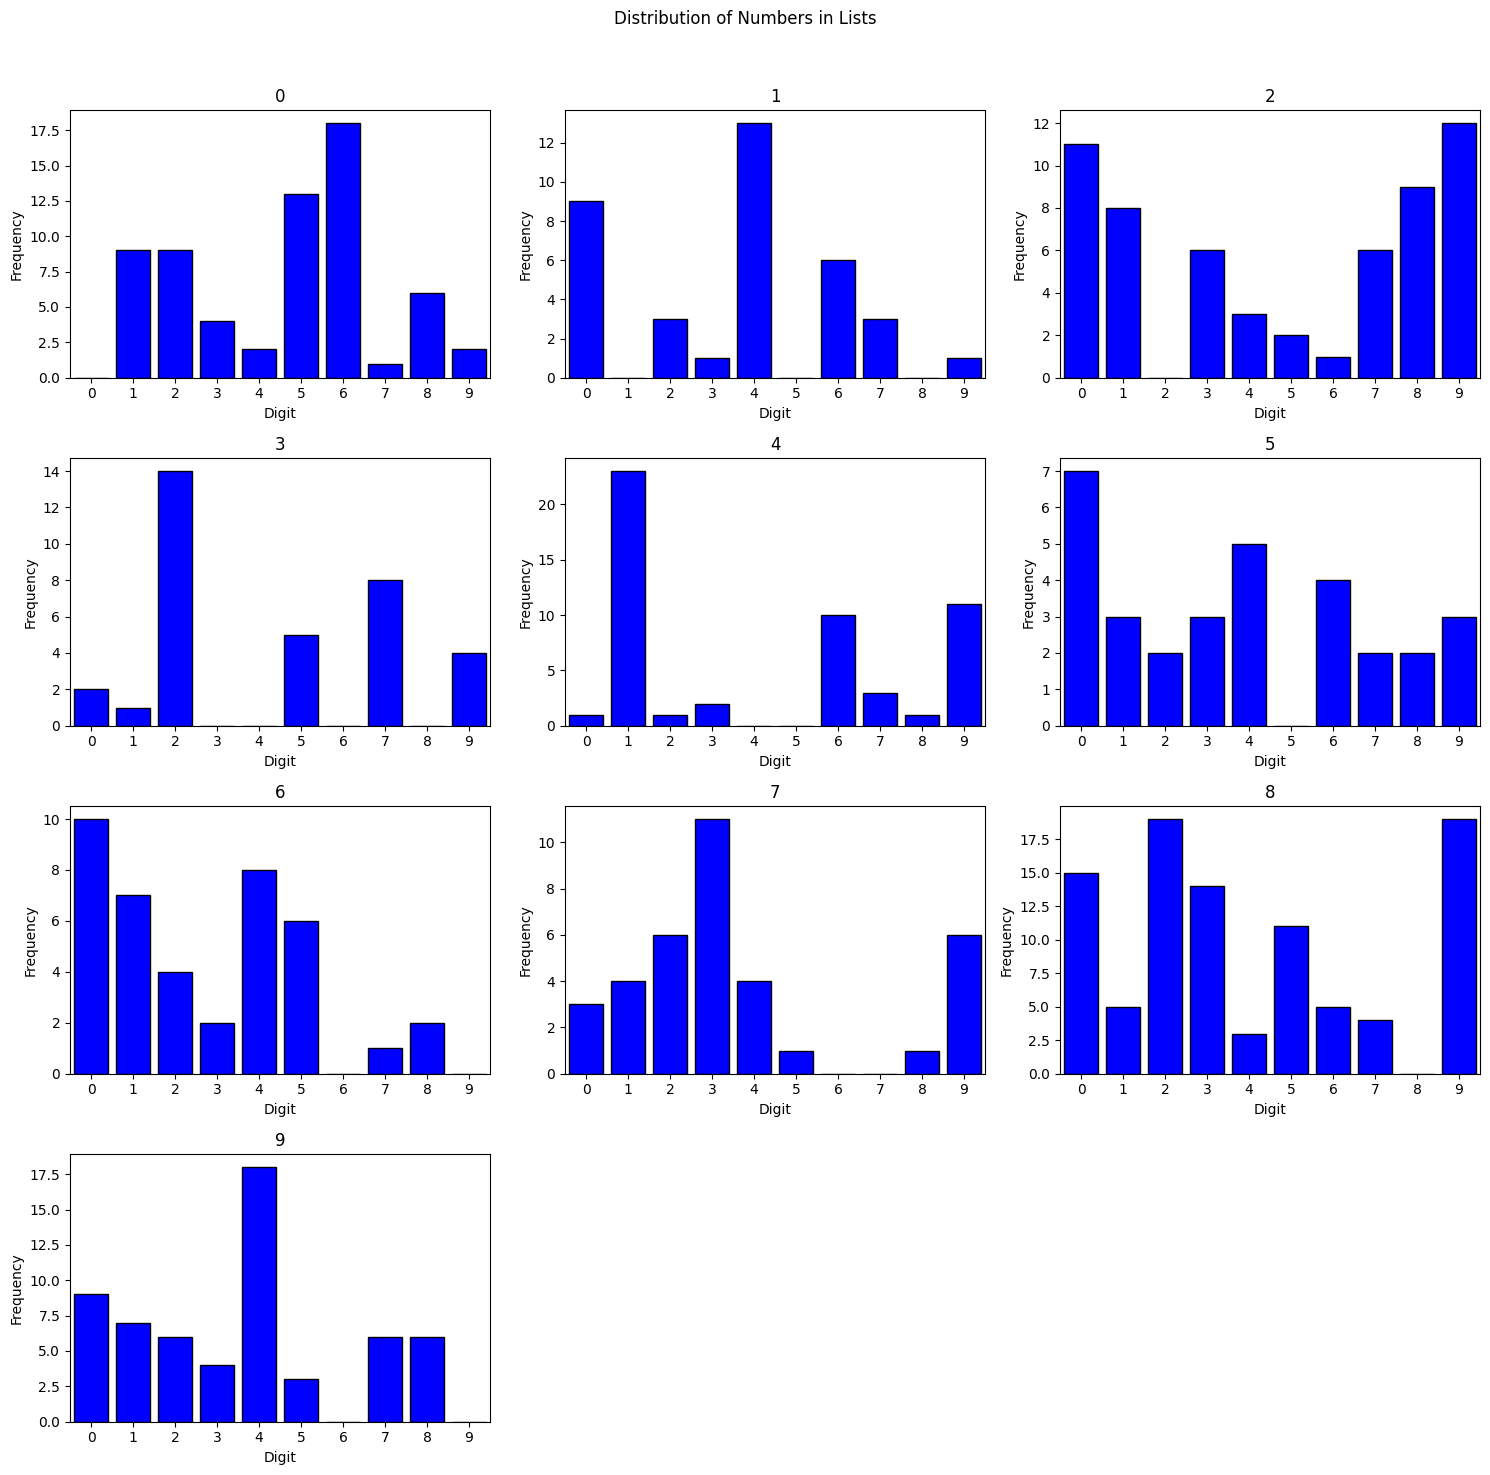

In [46]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle('Distribution of Numbers in Lists')

for i, (key, values) in enumerate(num_dict.items()):
    ax = axs[i // 3, i % 3]
    counts = np.bincount(values, minlength=10)  # Count occurrences of each number from 0 to 9
    ax.bar(range(10), counts, color='blue', edgecolor='black')
    ax.set_title(f'{key}')
    ax.set_xticks(range(10))
    ax.set_xlim(-0.5, 9.5)
    ax.set_xlabel('Digit')
    ax.set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, 12):
    fig.delaxes(axs[j // 3, j % 3])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()